# Case study: Pipeline-level differentiable programming demo
## Parametric shape optimization with differentiable FEM simulation

In this notebook, we explore the optimization of a parametric structure made of a linear elastic material. The structure is parametrized by N bars, each of which has M piecewise linear segments. We seek the ideal configuration of the $y$-coordinates of the vertices that connect those bar segments. This notebook is based on the [2D topology optimization example](https://github.com/deepmodeling/jax-fem/tree/main/demos/topology_optimization) from `jax-fem`, but we solve the problem using a parametric approach instead.

**That is, we use end-to-end automatic differentiation (AD) through several components to optimize the design variables directly with respect to (simulated) performance of the design.**

The design space is defined using a geometry library called PyVista, which does not support automatic differentiation. However, we can enable differentiability of this operation by using a finite difference approximation of the Jacobian matrix.

We denote the design space as a function $g$ that maps the design variables to a signed distance field. Then, we can then define the density field $\rho(\mathbf{x})$ as a function of the SDF value $g(\mathbf{x})$. Finally we denote the differentiable finite element method (FEM) solver as $f$, which takes the density field as input and returns the structure's compliance.  Therefore, the optimization problem can be formulated as follows:

\begin{equation}
\min_{\theta} f(\rho(g(\theta))).
\end{equation}

Here, $\theta$ is the vector of design variables (the $y$-coordinates of the vertices).

## AD and Tesseracts

![Parametric shape optimization](illustration.png)

Since we want use a gradient based optimizer, we need to compute the gradient of the compliance with respect to the design variables. Hence we are interested in the following derivative:

\begin{equation}
\frac{\partial f}{\partial\theta} = \frac{\partial f}{\partial \rho} \cdot \frac{\partial \rho}{\partial g} \cdot \frac{\partial g}{\partial\theta}
\end{equation}

Note that each term is a (Jacobian) matrix. With modern AD libraries such as [JAX](https://github.com/jax-ml/jax), backpropagation uses the vector-Jacobian-product to pull back the gradients over the entire pipeline, without ever materializing Jacobian matrices. This is a powerful feature, but it typically requires that the entire pipeline is implemented in a single monolithic application – which can be cumbersome and error-prone, and does not scale well to large applications or compute needs.

With Tesseracts, we wrap each function in a separate module and then compose them together. To enable differentiability, we also define AD-relevant endpoints, such as the vector-Jacobian product, inside each Tesseract module (`tesseract_api.py`).

To learn more about building and running Tesseracts, please refer to the [Tesseract documentation](https://docs.pasteurlabs.ai/projects/tesseract-core/latest/).

## Setup

Let's install the required packages and build the two Tesseract images. Building the Tesseracts can take a few minutes as they are Docker containers with quite a few dependencies.

In [1]:
# Install additional requirements for this notebook
%pip install -r requirements.txt -q --isolated

Note: you may need to restart the kernel to use updated packages.


In [2]:
import tesseract_core

tesseract_core.build_tesseract("design_tess", "latest")
tesseract_core.build_tesseract("fem_tess", "latest")
print("Tesseract built successfully.")

Tesseract built successfully.


## Design Space Tesseract

First, let's import the Tesseract Core library and start a server for the design space Tesseract, which is equivalent to the function $g$ in the equation above.

In [3]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
from tesseract_core import Tesseract

In [4]:
design_tess = Tesseract.from_image("design-tube-sdf")
design_tess.serve()

Now we can setup the parameters for the design space and apply the design Tesseract. The Tesseract constructs a 3D geometry using PyVista and computes its signed distance field (SDF).

In [5]:
n_chains = 4
n_edges_per_chain = 5
bar_radius = 1.0

Lx = 60
Ly = 30
Nx = 120
Ny = 60

# Initialize chain parameter array
initial_params = jnp.zeros((n_chains, n_edges_per_chain + 1, 3), dtype=jnp.float32)

for chain in range(n_chains):
    initial_params = initial_params.at[chain, :, 0].set(
        jnp.linspace(-Lx / 2, Lx / 2, n_edges_per_chain + 1)
    )

    # add an offset
    initial_params = initial_params.at[chain, :, 1].set(chain / n_chains * 10.0 - 5.0)

sdf = design_tess.apply(
    {
        "bar_params": initial_params,
        "bar_radius": bar_radius,
        "Lx": Lx,
        "Ly": Ly,
        "Nx": Nx,
        "Ny": Ny,
        "epsilon": 1e-3,  # epsilon, only used for FD of the jacobian
    }
)["sdf"]

print("SDF shape:", sdf.shape)

SDF shape: (120, 60)


To better understand what's going on, let's import some internal functions from the design Tesseract, and visualize the structure and its SDF field.

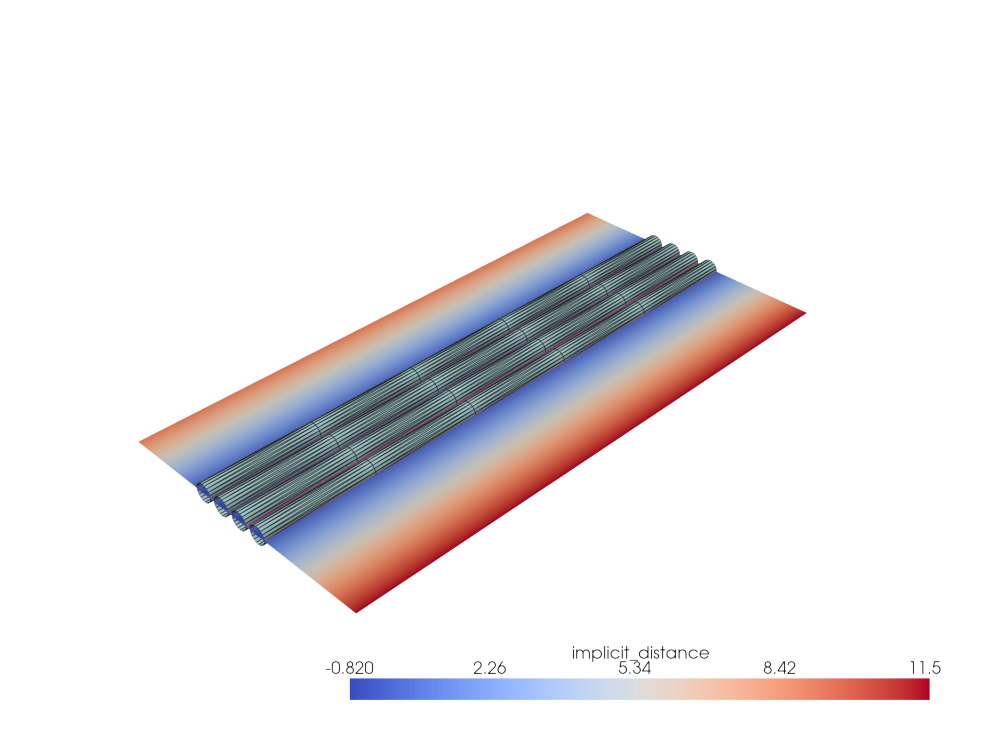

In [6]:
from design_tess.tesseract_api import build_geometry, compute_sdf
import pyvista as pv


def visualize(params, interactive=False):
    """Visualize the geometry defined by the parameters."""
    geometries = build_geometry(
        params,
        radius=bar_radius,
    )
    geometry = sum(geometries, start=pv.PolyData())
    sdf = compute_sdf(params, radius=bar_radius, Lx=Lx, Ly=Ly, Nx=Nx, Ny=Ny)
    isoval = sdf.contour(isosurfaces=[0.0], scalars="implicit_distance")

    plotter = pv.Plotter()
    plotter.add_mesh(geometry, color="lightblue", show_edges=True, edge_color="black")
    plotter.add_mesh(
        sdf, scalars="implicit_distance", cmap="coolwarm", show_edges=False
    )
    plotter.add_mesh(isoval, color="red", show_edges=True, line_width=2)

    if interactive:
        plotter.show()
    else:
        img = plotter.screenshot(return_img=True, scale=2, transparent_background=True)
        plt.figure(figsize=(10, 8))
        plt.axis("off")
        plt.imshow(img)
        plt.tight_layout()


visualize(initial_params)

Instead of calling the apply endpoint we can also call the vector-Jacobian product endpoint which is used for backpropagation (also called reverse-mode AD). This endpoint computes the derivative of the SDF with respect to the design variables, which is useful for gradient-based optimization. Hence we set the `vjp_inputs` to `bar_params` and the `vjp_outputs` to `sdf`, to indicate that we want to differentiate the SDF with respect to the shape parameters. 

In [7]:
grad = design_tess.vector_jacobian_product(
    inputs={
        "bar_params": initial_params,
        "bar_radius": bar_radius,
        "Lx": Lx,
        "Ly": Ly,
        "Nx": Nx,
        "Ny": Ny,
        "epsilon": 1e-3,  # epsilon, only used for FD of the jacobian
    },
    vjp_inputs=["bar_params"],
    vjp_outputs=["sdf"],
    cotangent_vector={"sdf": jnp.ones((Nx, Ny), dtype=jnp.float32)},
)["bar_params"]

print("Gradient shape:", grad.shape)

Gradient shape: (4, 6, 3)


Above we manually supplied all the relevant information regarding the VJP inputs, outputs, and cotangent vector. To make this easier, we can use the [Tesseract-JAX](https://github.com/pasteurlabs/tesseract-jax) library. Tesseract-JAX automatically registers Tesseracts as JAX primitives, which allows us to use JAX as an AD engine over functions that mix and match Tesseracts with regular JAX code. We can see this in action by using the `jax.vjp` function over `tesseract_jax.apply_tesseract`.

In [8]:
from tesseract_jax import apply_tesseract
import jax

primal, vjp_fun = jax.vjp(
    lambda params: apply_tesseract(
        design_tess,
        {
            "bar_params": params,
            "bar_radius": bar_radius,
            "Lx": Lx,
            "Ly": Ly,
            "Nx": Nx,
            "Ny": Ny,
            "epsilon": 0.01,  # Smoothing parameter for SDF computation
        },
    )["sdf"],
    initial_params,
)

grad = vjp_fun(jnp.ones((Nx, Ny), dtype=jnp.float32))[0]

print("Gradient shape:", grad.shape)

Gradient shape: (4, 6, 3)


## SDF to Density Field

Now that we have the signed distance field (SDF) from the design space, we can proceed to compute the *density field*, which is what the FEM solver expects. That is, we need to define a function $\rho$ that maps the SDF to a density value. This function needs to be smooth and differentiable to ensure that the optimization process can effectively navigate the design space. We use a parametrized sigmoid function, which ensures that the density values are bounded between 0 and 1. Here, $s$ is the slope of the sigmoid and $\varepsilon$ is the offset. The parameters $s$ and $\varepsilon$ can be adjusted to control the steepness and position of the transition between 0 and 1 in the density field.

\begin{equation}
    \rho(\text{SDF}) = \frac{1}{1 + e^{s \cdot \text{SDF} - \varepsilon}}
\end{equation}

Since this function is straightforward to implement, we can directly use the JAX library to define it.

In [9]:
def sdf_to_rho(
    sdf: jnp.ndarray, scale: float = 4.0, offset: float = 1.0
) -> jnp.ndarray:
    """
    Convert signed distance function to material density using sigmoid.

    Args:
        sdf: Signed distance function values.
        scale: Sigmoid steepness (higher = sharper transition).
        offset: SDF value where density = 0.5.

    Returns:
        Material density field in [0,1].
    """
    return 1 / (1 + jnp.exp(scale * sdf - offset))

To verify the conversion, we can visualize the density field:

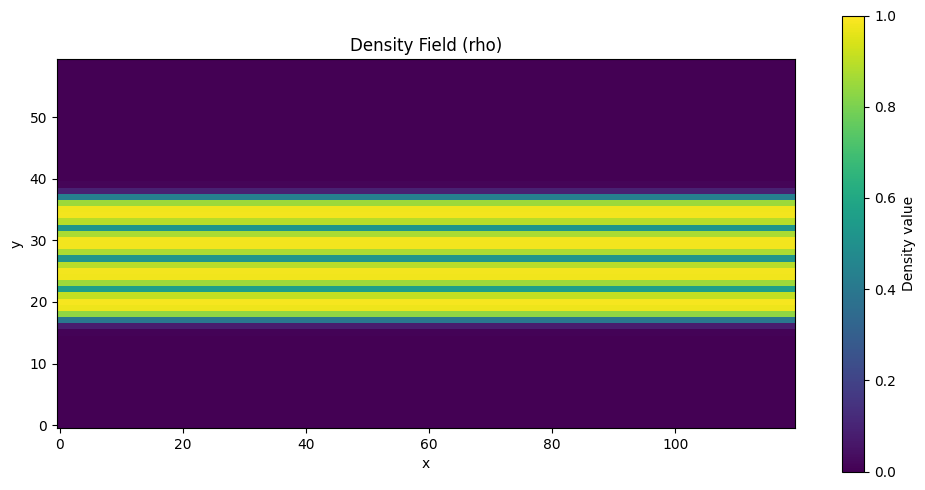

In [10]:
rho = sdf_to_rho(sdf)
fig, ax = plt.subplots(figsize=(10, 5))
im = ax.imshow(rho.T, origin="lower", cmap="viridis", vmin=0, vmax=1)
ax.set_title("Density Field (rho)")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.colorbar(im, ax=ax, label="Density value")
plt.tight_layout()

## FEM Tesseract

Now that we have a density field, we compute the *compliance* of the structure (~stiffness against deformation). That is, we find the most stable configuration of the structure under a given load. The compliance is computed using a finite element method (FEM) solver, which is implemented in the FEM Tesseract. The FEM Tesseract takes the density field as input and returns the compliance of the structure.

The compliance Tesseract is using the jax-fem finite element library, which is fully auto-differentiable. Inside the Tesseract the boundary conditions are already hard coded, where the entire left side is subject to a Dirichlet boundary condition and bottom right side to a Neumann boundary condition.

In [11]:
fem_tess = Tesseract.from_image("structure-jax-fem")
fem_tess.serve()

In [12]:
compliance = apply_tesseract(
    fem_tess,
    {
        "rho": jnp.reshape(rho, (Nx * Ny, 1)),
        "Lx": Lx,
        "Ly": Ly,
        "Nx": Nx,
        "Ny": Ny,
    },
)["compliance"]
print(f"Compliance: {compliance:.4f}")

Compliance: 6261.0449


## Gradient-based parametric shape optimization

Now that we have all the components of the pipeline, we can compose them together and define the loss function for the optimization. The loss function is simply the compliance of the structure, which we can compute by applying the FEM Tesseract to the density field obtained from the design space Tesseract.

**This function looks trivial, but it is actually a complex pipeline that involves several components, each of which is differentiable.** The complexity is hidden behind the Tesseract implementation, which allows us to compose the components together and use them as a single function, without worrying about the details of the implementation.

In [13]:
def loss(params: jnp.ndarray) -> float:
    """
    Compute structural compliance for given bar parameters.

    Args:
        params: Bar parameter array with shape (n_chains, n_nodes, 3).

    Returns:
        Structural compliance (scalar). Lower values indicate better performance.
    """

    # -- Tess 1 (design) --
    # Generate signed distance field from design parameters
    sdf = apply_tesseract(
        design_tess,
        {
            "bar_params": params,
            "bar_radius": bar_radius,
            "Lx": Lx,
            "Ly": Ly,
            "Nx": Nx,
            "Ny": Ny,
            "epsilon": 1e-4,  # epsilon for finite difference
        },
    )["sdf"]

    # -- Local JAX code --
    # Convert SDF to material density distribution
    rho = sdf_to_rho(sdf)

    # -- Tess 2 (FEM) --
    # Compute structural compliance via finite element analysis
    compliance = apply_tesseract(
        fem_tess,
        {
            "rho": jnp.reshape(rho, (Nx * Ny, 1)),  # Flatten for FEM solver
            "Lx": Lx,
            "Ly": Ly,
            "Nx": Nx,
            "Ny": Ny,
        },
    )["compliance"]
    return compliance

Now we can use JAX's `grad` function to compute the gradient of the compliance with respect to the design variables. We use a simple gradient descent optimizer to perform the optimization towards a local minimum. This is not a very sophisticated optimization approach, but it serves as a good starting point. The optimization process will take a few minutes to run.

In [14]:
import optax

solver = optax.sgd(1e-2, momentum=0.9)
opt_state = solver.init(initial_params)

params = initial_params.copy()
loss_hist = []
params_hist = []

grad_fn = jax.jit(jax.value_and_grad(loss))

for i in range(40):
    loss_value, grads = grad_fn(params)
    updates, opt_state = solver.update(
        grads, opt_state, params, value=loss_value, grad=grads, value_fn=loss
    )
    params = optax.apply_updates(params, updates)

    # Ensure parameters are within bounds
    params = params.at[..., 1].set(
        jnp.clip(params[..., 1], -Ly / 2 + bar_radius, Ly / 2 - bar_radius)
    )

    loss_hist.append(loss_value)
    params_hist.append(params)

    print(f"Iteration {i + 1}, Loss: {loss_value:.2f}")

Iteration 1, Loss: 6261.04
Iteration 2, Loss: 4831.73
Iteration 3, Loss: 1827.27
Iteration 4, Loss: 1492.60
Iteration 5, Loss: 959.53
Iteration 6, Loss: 786.41
Iteration 7, Loss: 804.06
Iteration 8, Loss: 761.18
Iteration 9, Loss: 680.34
Iteration 10, Loss: 599.67
Iteration 11, Loss: 523.74
Iteration 12, Loss: 469.71
Iteration 13, Loss: 458.43
Iteration 14, Loss: 486.32
Iteration 15, Loss: 574.79
Iteration 16, Loss: 518.89
Iteration 17, Loss: 334.98
Iteration 18, Loss: 315.33
Iteration 19, Loss: 305.10
Iteration 20, Loss: 308.83
Iteration 21, Loss: 297.32
Iteration 22, Loss: 276.73
Iteration 23, Loss: 263.01
Iteration 24, Loss: 260.59
Iteration 25, Loss: 268.03
Iteration 26, Loss: 269.70
Iteration 27, Loss: 267.73
Iteration 28, Loss: 261.94
Iteration 29, Loss: 260.76
Iteration 30, Loss: 260.25
Iteration 31, Loss: 256.45
Iteration 32, Loss: 250.16
Iteration 33, Loss: 243.46
Iteration 34, Loss: 237.65
Iteration 35, Loss: 234.32
Iteration 36, Loss: 232.08
Iteration 37, Loss: 231.28
Iterat

Lets plot the compliance as a function of the optimization steps. We can see that the compliance is decreasing smoothly, indicating that the optimization is working as expected. 

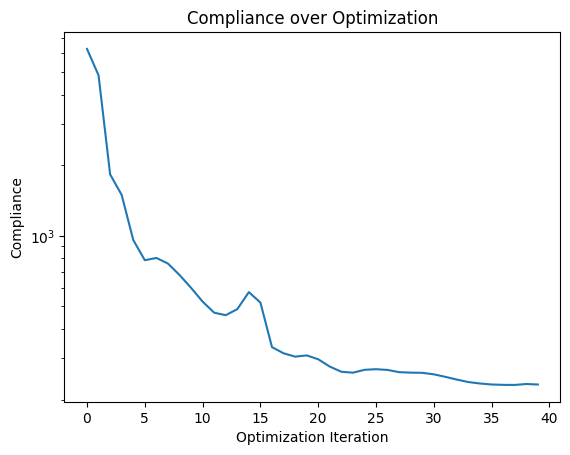

In [15]:
plt.plot(loss_hist)
plt.yscale("log")
plt.xlabel("Optimization Iteration")
plt.ylabel("Compliance")
plt.title("Compliance over Optimization");

We can also trace the y coordinates of the vertices over the optimization steps. This gives us an idea of how the design variables are changing during the optimization process.

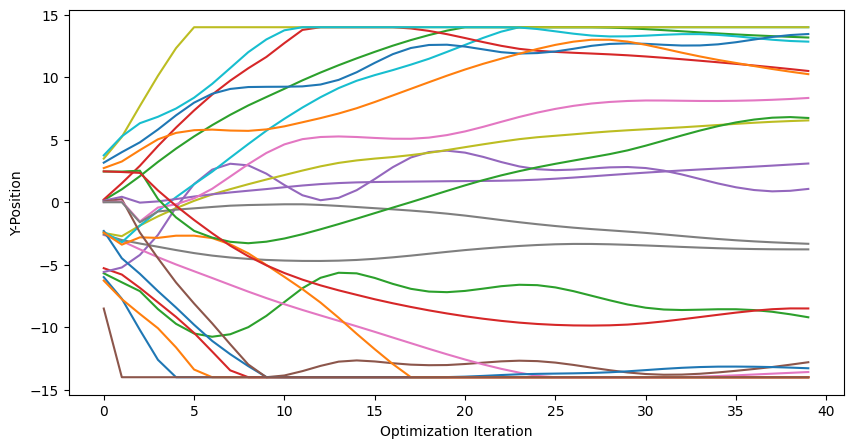

In [16]:
param_hist_tensor = jnp.array(params_hist)

plt.figure(figsize=(10, 5))

for chain in range(n_chains):
    for edge in range(n_edges_per_chain + 1):
        plt.plot(
            param_hist_tensor[:, chain, edge, 1].T, label=f"Chain {chain}, Edge {edge}"
        )

plt.xlabel("Optimization Iteration")
plt.ylabel("Y-Position");

## Visualize results

After optimization, the structure has been adjusted to assume a more stable configuration under the given load. The design variables have been tuned to achieve this goal, reducing the compliance of the structure from around 10,000 to about 200.

Here is the final optimized structure:

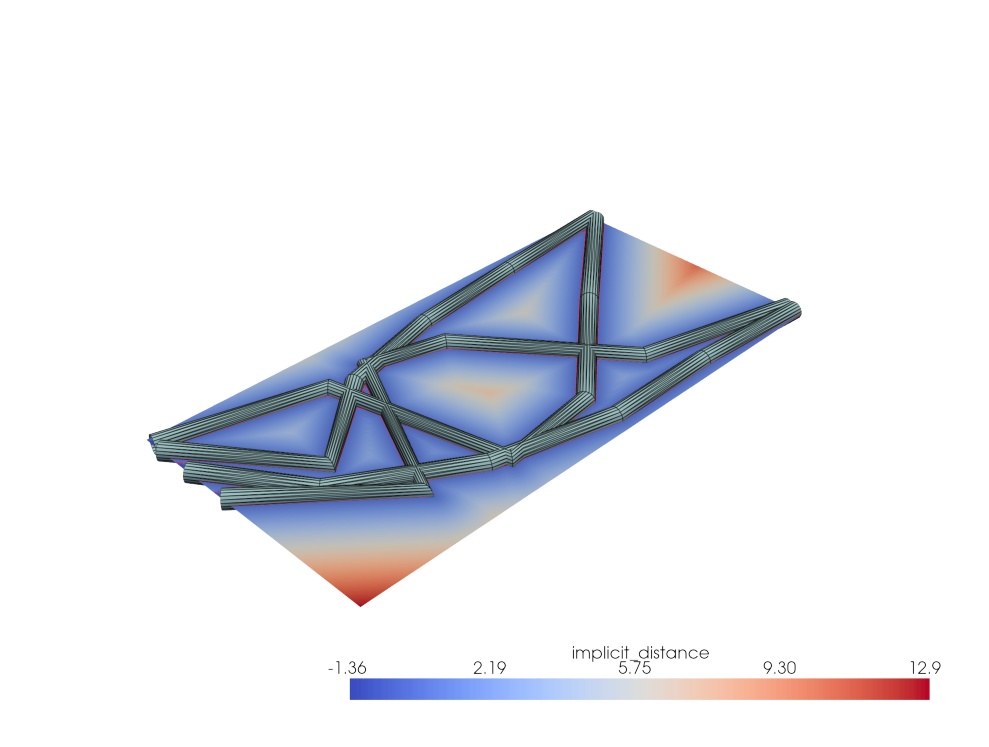

In [17]:
visualize(params)

We generate a video of the optimization process to visualize how the structure evolves over time.

In [18]:
from matplotlib import animation

# repeat the last frame a few times to show the final result
params_hist = params_hist + [params] * 20

fig = plt.figure(figsize=(7, 4))

ims = []
for params in params_hist:
    sdf = apply_tesseract(
        design_tess,
        {
            "bar_params": params,
            "bar_radius": bar_radius,
            "Lx": Lx,
            "Ly": Ly,
            "Nx": Nx,
            "Ny": Ny,
            "epsilon": 1e-3,
        },
    )["sdf"]

    rho = sdf_to_rho(sdf)

    im = plt.imshow(rho.T, origin="lower", cmap="viridis", vmin=0, vmax=1)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=10, blit=True, repeat_delay=2)
plt.close(fig)

ani.save("rho_optim.gif", writer="pillow", fps=10)

from IPython.display import HTML

HTML(ani.to_jshtml(fps=10, embed_frames=True))

Finally, lets compare the parametric optimization against the original free form topology optimization example from jax-fem. 

That is, we compare our results to the results obtains from a pixel-wise optimization of the density field, which is a common approach in topology optimization. However, it often leads to final designs that are not manufacturable, as they can have complex geometries that are difficult to fabricate. In contrast, our parametric approach leads to more fine-grained control over the solution space – and apparently very similar results, despite our simplistic approach.

| Parametric Optimization (Ours) | Free Form Topology Optimization (jax-fem example) |
|-------------------------|---------------------------------|
| ![param](rho_optim.gif) | ![param](free_form.gif)         |

In [19]:
# Tear down Tesseracts after use
design_tess.teardown()
fem_tess.teardown()

## Eager to learn more?

- 👉 [Join the Tesseract Community Forum](https://si-tesseract.discourse.group/)
- 👉 [Visit Tesseract Core on GitHub](https://github.com/pasteurlabs/tesseract-core)
- 👉 [Visit Tesseract-JAX on GitHub](https://github.com/pasteurlabs/tesseract-jax)

Questions? Feedback? Please reach out through the [Tesseract Community Forum](https://si-tesseract.discourse.group/).